In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
def splitData(data, ratio):
    np.random.shuffle(data)
    train_size = int(len(data) * ratio)
    train_set = data[:train_size]
    test_set = data[train_size:]
    return train_set, test_set

In [5]:
def timeToMinutes(time):
    splitted = time.split(":")
    if int(splitted[0]) > 23 or int(splitted[1]) > 59:
        raise ValueError
    return int(splitted[0]) * 60 + int(splitted[1])

In [6]:
def processTime(time):
    minutes = timeToMinutes(time)
    return  math.sin(minutes / (24 * 60)*math.pi)

In [7]:
def loadData(codesToIndexes):
    data = []
    for i in range(1, 70):
        filePrefix = 'Diabetes-Data/data-'
        if i < 10:
            filePrefix += '0'
        fileHandle = open(filePrefix+str(i), 'r')
        for line in fileHandle:
            line = line.strip()
            if line:
                try:
                    parts = line.split('\t')
                    time = processTime(parts[1])
                    code = int(parts[2])
                    if code not in codesToIndexes.keys():
                        raise ValueError
                    number = int(parts[3])
                    data.append([time, code, number])
                except ValueError:
                    pass
                except IndexError:
                    pass
        
        fileHandle.close()
    return data


In [8]:
def encodeOutput(Y,codesToIndexes):
    Y_encoded = np.zeros((Y.shape[0], 20))
    for i, code in enumerate(Y):
        index = codesToIndexes[code]
        Y_encoded[i, index] = 1
    return Y_encoded

In [10]:
def getEncodedDatasets():
    codesToIndexes = {33:0, 34:1, 35:2, 48:3, 57:4, 58:5, 59:6, 60:7, 61:8, 62:9, 63:10, 64:11, 65:12, 66:13, 67:14, 68:15, 69:16, 70:17, 71:18, 72:19}
    data = np.array(loadData(codesToIndexes))
    train, test = splitData(data, 0.8)
    X_train = train[:, [0, 2]]
    X_test = test[:, [0, 2]]
    Y_train = train[:, 1]
    Y_test = test[:, 1]
    Y_train_encoded = encodeOutput(Y_train,codesToIndexes)
    Y_test_encoded = encodeOutput(Y_test,codesToIndexes)
    return X_test, Y_test_encoded, X_train, Y_train_encoded

In [11]:
def initializeParameters(nX, nH, nY, numberOfHiddenLayers=1):
    parameters = {}
    if numberOfHiddenLayers < 1:
        raise ValueError   
    if numberOfHiddenLayers == 1:
        parameters["W1"] = np.random.randn(nX, nH)
        parameters["b1"] = np.zeros((1,nH))
    if numberOfHiddenLayers > 1:
        parameters["W1"] = np.random.randn(nX, nH[0])
        parameters["b1"] = np.zeros((1,nH[0]))
        for i in range(2, numberOfHiddenLayers+1):
            parameters["W"+str(i)] = np.random.randn(nH[i-2], nH[i-1])
            parameters["b"+str(i)] = np.zeros((1,nH[i-1]))
    if numberOfHiddenLayers == 1:
        parameters["W"+str(numberOfHiddenLayers+1)] = np.random.randn(nH, nY)
    else:
        parameters["W"+str(numberOfHiddenLayers+1)] = np.random.randn(nH[-1], nY)
    parameters["b"+str(numberOfHiddenLayers+1)] = np.zeros((1,nY))
    return parameters

### Funkcje aktywacji

- **Warstwy ukryte:** Sigmoid
  - $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
- **Warstwa wyjściowa:** Softmax
  - $$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

### Propagacja w przód

Dla każdej warstwy l (od 1 do L+1, gdzie L+1 to warstwa wyjściowa):

1. **Sygnał wejściowy:** $$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
2. **Aktywacja:** 
   - Dla warstw ukrytych: $$A^{[l]} = \sigma(Z^{[l]})$$
   - Dla warstwy wyjściowej: $$A^{[L+1]} = \text{Softmax}(Z^{[L+1]})$$

### Wsteczna propagacja błędu

1. **Błąd na wyjściu (warstwa L+1):**
   - $$\delta^{[L+1]} = A^{[L+1]} - Y$$

Dla każdej warstwy l od L do 1:

2. **Błąd dla warstwy l:**
   - $$\delta^{[l]} = (W^{[l+1]T} \delta^{[l+1]}) \odot \sigma'(Z^{[l]})$$
3. **Gradient dla wag i biasów:**
   - $$\nabla W^{[l]} = \delta^{[l]} A^{[l-1]T}$$
   - $$\nabla b^{[l]} = \sum(\delta^{[l]}, \text{axis} = 0)$$



In [12]:
def costFunction(Y, Y_hat):
    return - np.sum(Y * np.log(Y_hat))

In [13]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [14]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

In [15]:
def propagate(X, Y, parameters):
    # if len(parameters)//2 > 1:            
    A = X
    history = {"A0": X}
    gradients = {}
    for i in range(1, len(parameters)//2+1):
        Z = np.dot(A, parameters["W"+str(i)]) + parameters["b"+str(i)]
        history["Z"+str(i)] = Z
        if i != len(parameters)//2:
            A = sigmoid(Z)
        else:
            A = softmax(Z)
        history["A"+str(i)] = A
    
    cost = costFunction(Y, A)
    gradients = {}
    
    for i in range(len(parameters)//2, 0, -1):
        if i == len(parameters)//2:
            history["dA"+str(i)]= history["A"+str(i)] - Y
        else:
            history["dA"+str(i)] = np.dot(history["dA"+str(i+1)], parameters["W"+str(i+1)].T) * history["A"+str(i)] * (1 - history["A"+str(i)])
        
        gradients["dW"+str(i)] = np.dot(history["A"+str(i-1)].T,history["dA"+str(i)])
        gradients["db"+str(i)] = np.sum(history["dA"+str(i)], axis=0)
    # if len(parameters)//2 == 1:

    #     Z1 = np.dot(X, parameters["W1"]) + parameters["b1"]
    #     A1 = sigmoid(Z1)
    #     Z2 = np.dot(A1, parameters["W2"]) + parameters["b2"]
    #     A2 = softmax(Z2)
    #     cost = costFunction(Y, A2)
    #     # # pochodne funkcji straty:
    #     dA2 = A2 - Y
    #     dW2 = np.dot(A1.T,dA2) 
    #     db2 = np.sum(dA2, axis=0,keepdims=True)
    #     dA1 = np.dot(dA2, parameters["W2"].T)
    #     dZ1 = dA1 * (A1 * (1 - A1))
    #     dW1 = np.dot(X.T, dZ1)
    #     db1 = np.sum(dZ1, axis=0)
    #     gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients, cost


### Aktualizacja wag

- Wagi i biasy są aktualizowane za pomocą metody spadku gradientu:
  - $$W^{[l]} = W^{[l]} - \alpha \nabla W^{[l]}$$
  - $$b^{[l]} = b^{[l]} - \alpha \nabla b^{[l]}$$

In [16]:
def updateParameters(parameters, gradients, learningRate):
    for key in parameters.keys():
        parameters[key] += - learningRate * gradients["d"+key]
    return parameters

In [17]:
def optimize(X, Y, parameters, learningRate, numberOfIterations, printCost=False):
    costs = []
    for i in range(numberOfIterations):
        gradients, cost = propagate(X, Y, parameters)
        parameters = updateParameters(parameters, gradients, learningRate)
        costs.append(cost)
        if i % 100 == 0 and printCost:
            print("Cost after iteration {}: {}".format(i, cost))
    return parameters, costs

In [18]:
def predict(X, parameters):
    Z = X
    for i in range(1, len(parameters)//2):
        Z = np.dot(Z, parameters["W"+str(i)]) + parameters["b"+str(i)]
        Z = sigmoid(Z)
    Z = np.dot(Z, parameters["W"+str(len(parameters)//2)]) + parameters["b"+str(len(parameters)//2)]
    Z = softmax(Z)
    return np.argmax(Z, axis=1)

In [19]:
X_test, Y_test, X_train, Y_train =getEncodedDatasets()
# parameters = initializeParameters(2, [5,15], 20,2)
parameters = initializeParameters(2, 15, 20,1)
params, costs = optimize(X_train,Y_train, parameters, 0.00001, 5000, True)

Cost after iteration 0: 129437.22112405988


/tmp/ipykernel_4962/70635953.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


Cost after iteration 100: 48029.788708621585
Cost after iteration 200: 44164.88649996472
Cost after iteration 300: 41532.34074351513
Cost after iteration 400: 39332.00588160136
Cost after iteration 500: 37694.337666083105
Cost after iteration 600: 36415.681159710235
Cost after iteration 700: 34550.66633591541
Cost after iteration 800: 33905.256187943
Cost after iteration 900: 33946.09668515923
Cost after iteration 1000: 32971.53407648512
Cost after iteration 1100: 32659.776669409035
Cost after iteration 1200: 32853.84472466655
Cost after iteration 1300: 32642.52573474872
Cost after iteration 1400: 32454.982286188737
Cost after iteration 1500: 32296.06395361123
Cost after iteration 1600: 32161.112737219868
Cost after iteration 1700: 32045.685454530685
Cost after iteration 1800: 31946.10718229219
Cost after iteration 1900: 31859.440308270685
Cost after iteration 2000: 31783.35144135256
Cost after iteration 2100: 31715.97858794724
Cost after iteration 2200: 31655.818263745932
Cost after i

In [20]:
a = predict(X_train, params)
i=18
print(a[i])
sum =0
timesGuessedA = {}
timesGuessedY = {}
trafione = {}
for i in range(a.shape[0]):
    timesGuessedA[a[i]] = timesGuessedA.get(a[i], 0) + 1    
    timesGuessedY[np.argmax(Y_train[i])] = timesGuessedY.get(np.argmax(Y_train[i]), 0) + 1
    if a[i] == np.argmax(Y_train[i]):
        trafione[a[i]] = trafione.get(a[i], 0) + 1
        sum += 1

print(sum,a.shape[0])
print(timesGuessedA)
print(timesGuessedY)
print(trafione)
print(sum/a.shape[0]*100)

/tmp/ipykernel_4962/70635953.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


0
11462 22988
{0: 8558, 5: 10331, 1: 3020, 12: 677, 14: 334, 7: 68}
{1: 2971, 9: 2504, 3: 1488, 0: 7428, 2: 836, 13: 125, 4: 830, 7: 2175, 5: 2811, 11: 705, 14: 266, 15: 28, 18: 69, 10: 172, 12: 267, 8: 52, 17: 112, 19: 72, 16: 60, 6: 17}
{0: 6828, 5: 2733, 1: 1616, 12: 176, 14: 87, 7: 22}
49.860796937532626


In [21]:
a = predict(X_test, params)
i=18
print(a[i])
sum =0
timesGuessedA = {}
timesGuessedY = {}
trafione = {}
for i in range(a.shape[0]):
    timesGuessedA[a[i]] = timesGuessedA.get(a[i], 0) + 1    
    timesGuessedY[np.argmax(Y_test[i])] = timesGuessedY.get(np.argmax(Y_test[i]), 0) + 1
    if a[i] == np.argmax(Y_test[i]):
        trafione[a[i]] = trafione.get(a[i], 0) + 1
        sum += 1

print(sum,a.shape[0])
print(timesGuessedA)
print(timesGuessedY)
print(trafione)
print(sum/a.shape[0]*100)

0
2868 5747
{5: 2555, 0: 2210, 1: 717, 7: 13, 12: 161, 14: 91}
{9: 614, 5: 668, 0: 1918, 7: 583, 1: 709, 3: 371, 10: 47, 14: 60, 2: 217, 4: 159, 13: 29, 11: 199, 17: 27, 12: 64, 8: 14, 16: 8, 18: 29, 15: 6, 19: 22, 6: 3}
{5: 657, 0: 1770, 1: 373, 7: 1, 12: 43, 14: 24}
49.90429789455368


/tmp/ipykernel_4962/70635953.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


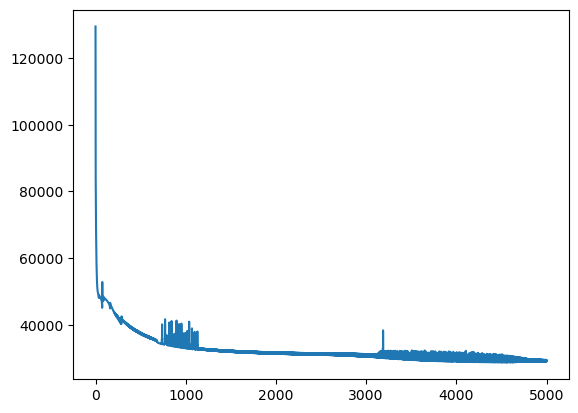

In [23]:
plt.plot(costs)